In [1]:
!pip install gym==0.26.2 pygame torch


In [2]:
!pip install numpy==1.23.5


In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

# Hyperparameters
lr_actor = 1e-3
lr_critic = 1e-3
gamma = 0.99
tau = 0.005
buffer_size = int(1e6)
batch_size = 64

env = gym.make('Pendulum-v1')  # No rendering in Colab

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, action_dim), nn.Tanh()
        )
        self.max_action = max_action

    def forward(self, state):
        return self.max_action * self.net(state)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))

# Replay Buffer
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
        return (torch.FloatTensor(states),
                torch.FloatTensor(actions),
                torch.FloatTensor(rewards).unsqueeze(1),
                torch.FloatTensor(next_states),
                torch.FloatTensor(dones).unsqueeze(1))

# Initialize networks
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

actor = Actor(state_dim, action_dim, max_action)
actor_target = Actor(state_dim, action_dim, max_action)
critic = Critic(state_dim, action_dim)
critic_target = Critic(state_dim, action_dim)

actor_target.load_state_dict(actor.state_dict())
critic_target.load_state_dict(critic.state_dict())

actor_optimizer = optim.Adam(actor.parameters(), lr=lr_actor)
critic_optimizer = optim.Adam(critic.parameters(), lr=lr_critic)

replay_buffer = ReplayBuffer(buffer_size)

# Training Loop
episodes = 200
reward_history = []
for ep in range(episodes):
    state, _ = env.reset()
    episode_reward = 0
    for step in range(200):
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        action = actor(state_tensor).detach().numpy()[0]
        action = action + np.random.normal(0, 0.1, size=action_dim)  # Exploration noise
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer.add(state, action, reward, next_state, float(done))
        state = next_state
        episode_reward += reward

        if len(replay_buffer.buffer) > batch_size:
            # Sample and Train
            s, a, r, s_next, d = replay_buffer.sample(batch_size)

            # Critic Loss
            target_q = critic_target(s_next, actor_target(s_next))
            target_value = r + (1 - d) * gamma * target_q
            critic_loss = nn.MSELoss()(critic(s, a), target_value.detach())
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Actor Loss
            actor_loss = -critic(s, actor(s)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # Soft Update
            for param, target_param in zip(critic.parameters(), critic_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
            for param, target_param in zip(actor.parameters(), actor_target.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        if done:
            break

    reward_history.append(episode_reward)
    print(f"Episode {ep+1}, Reward: {episode_reward:.2f}")

env.close()


Episode 1, Reward: -1481.11
Episode 2, Reward: -1491.99
Episode 3, Reward: -1625.84
Episode 4, Reward: -1382.25
Episode 5, Reward: -1395.25
Episode 6, Reward: -1586.03
Episode 7, Reward: -1733.09
Episode 8, Reward: -1730.79
Episode 9, Reward: -1669.12
Episode 10, Reward: -1718.94
Episode 11, Reward: -1560.74
Episode 12, Reward: -1697.92
Episode 13, Reward: -1113.45
Episode 14, Reward: -1243.23
Episode 15, Reward: -1430.32
Episode 16, Reward: -1345.87
Episode 17, Reward: -987.81
Episode 18, Reward: -868.38
Episode 19, Reward: -1158.11
Episode 20, Reward: -993.46
Episode 21, Reward: -1073.23
Episode 22, Reward: -1074.89
Episode 23, Reward: -1004.18
Episode 24, Reward: -1048.03
Episode 25, Reward: -1141.37
Episode 26, Reward: -1058.09
Episode 27, Reward: -1307.38
Episode 28, Reward: -1145.20
Episode 29, Reward: -1007.64
Episode 30, Reward: -1029.65
Episode 31, Reward: -1082.03
Episode 32, Reward: -901.62
Episode 33, Reward: -1023.31
Episode 34, Reward: -1068.70
Episode 35, Reward: -1054.0

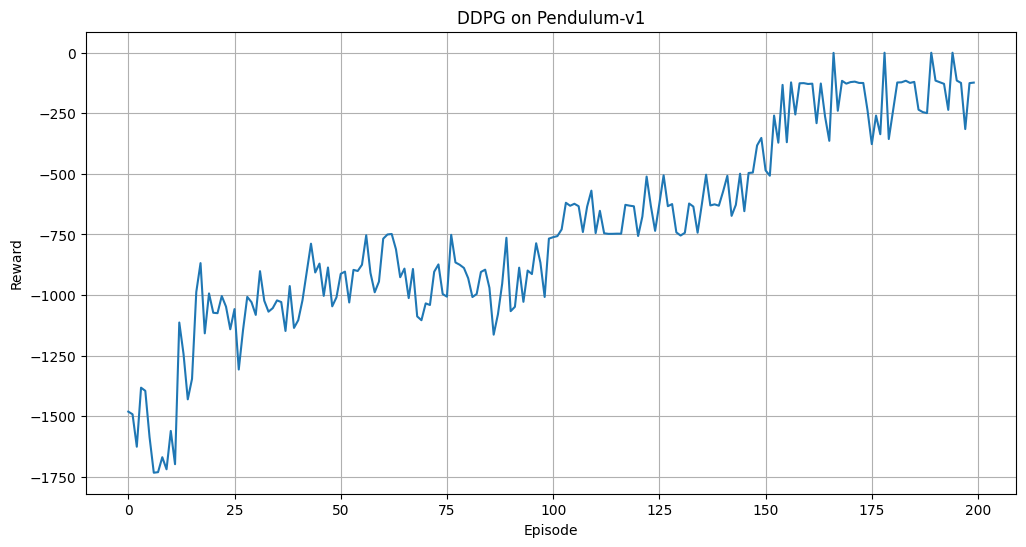

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(reward_history)
plt.title('DDPG on Pendulum-v1')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid(True)
plt.show()


In [5]:
torch.save(actor.state_dict(), "ddpg_pendulum_actor.pth")
torch.save(critic.state_dict(), "ddpg_pendulum_critic.pth")


In [6]:
state, _ = env.reset()
total_reward = 0
for _ in range(200):
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    action = actor(state_tensor).detach().numpy()[0]  # No exploration noise
    state, reward, terminated, truncated, _ = env.step(action)
    total_reward += reward
    if terminated or truncated:
        break
print(f"Test Episode Reward (Deterministic): {total_reward:.2f}")


Test Episode Reward (Deterministic): -1.01
